In [1]:
from stable_baselines3 import PPO

import pandas as pd
import numpy as np

from captum.attr import ShapleyValueSampling, FeaturePermutation
import torch
#import plotly.figure_factory as ff
#import plotly.express as px
import matplotlib.pyplot as plt

import KBMproject.utilities as utils

%matplotlib inline

In [2]:
import matplotlib.pylab as pylab

params = {'axes.labelsize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'legend.fontsize': 'x-large',
          #'font.size': 16,
          'axes.titlesize': 'x-large',
          'figure.titlesize': 'x-large',
          }
pylab.rcParams.update(params)

In [3]:
AGENT_NAME = '20 bin PPO 500 results\default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_500.zip'
ATLA_NAME = 'Models\ATLA\PPO agent 100 alts over 1000+200 2-3-21.zip'
SAMPLES = 10_000

In [4]:
agent = PPO.load(path=f"{AGENT_NAME}")
atla =  PPO.load(path=f"{ATLA_NAME}")

In [5]:
agent_svs = ShapleyValueSampling(utils.extract_actor(agent))
atla_svs = ShapleyValueSampling(utils.extract_actor(atla))

In [6]:
agent_fp = FeaturePermutation(utils.extract_actor(agent))
atla_fp = FeaturePermutation(utils.extract_actor(atla))

In [7]:
df_agent = pd.read_csv(r'20 bin PPO 500 results\rebaseline obs.csv',)
df_agent['actions'] = pd.read_csv(r'20 bin PPO 500 results\rebaseline a.csv',)

In [8]:
df_atla = pd.read_csv(r'PPO agent 100 alts over 1000+200 2-3-21 results\baseline_obs-a.csv',
                       index_col=0,
                       #header=0,
                       dtype='float32')

In [9]:
agent_shap = agent_svs.attribute(torch.from_numpy(df_agent.drop(columns=['actions']).to_numpy().astype('float32')).to('cuda'),
                             target=torch.from_numpy(df_agent['actions'].to_numpy().astype('int64')).to('cuda'),
                             n_samples=SAMPLES,
                             show_progress=True,
                             ).detach().cpu().numpy()

Shapley Value Sampling attribution:   0%|          | 0/310001 [00:00<?, ?it/s]

In [10]:
atla_shap = agent_svs.attribute(torch.from_numpy(df_atla.drop(columns=['actions']).to_numpy().astype('float32')).to('cuda'),
                             target=torch.from_numpy(df_atla['actions'].to_numpy().astype('int64')).to('cuda'),
                             n_samples=SAMPLES,
                             show_progress=True,
                             ).detach().cpu().numpy()

Shapley Value Sampling attribution:   0%|          | 0/310001 [00:00<?, ?it/s]

In [11]:
df_mean_shap = pd.DataFrame([np.abs(agent_shap).mean(axis=0),np.abs(atla_shap).mean(axis=0)],
                            index=['500_Training_Episodes','500_Training_Episodes_Plus_ATLA'],
                            columns=df_atla.columns[:-1])

<Axes: title={'center': 'Mean Shapley Value Sampling Feature Importance Over One Episode'}, xlabel='Features', ylabel='Mean Absolute Shapley Value Sample'>

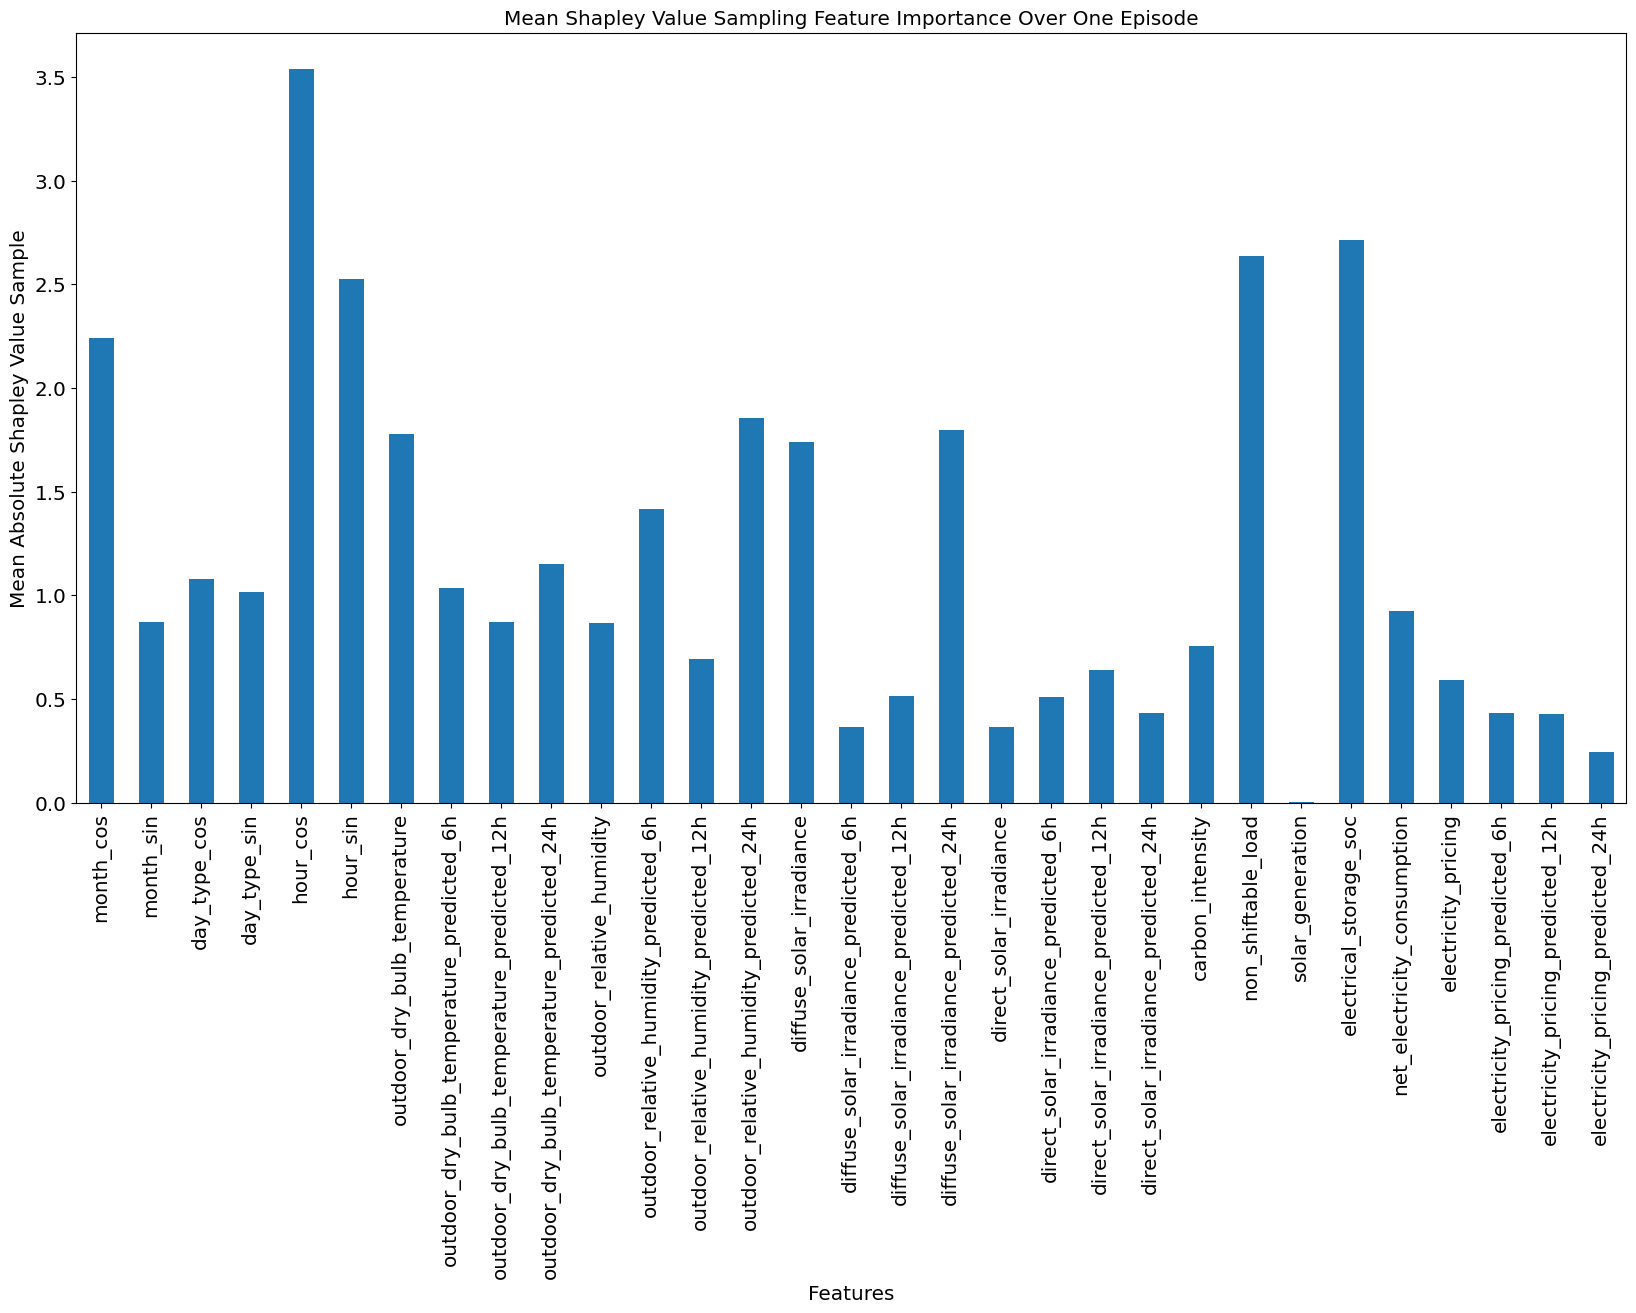

In [12]:
df_mean_shap.T['500_Training_Episodes'].abs().plot.bar(
    xlabel='Features',
    ylabel='Mean Absolute Shapley Value Sample',
    title='Mean Shapley Value Sampling Feature Importance Over One Episode',
    figsize=(20,10),
)

Text(0.5, 0, 'Mean Absolute Shapley Value Sample')

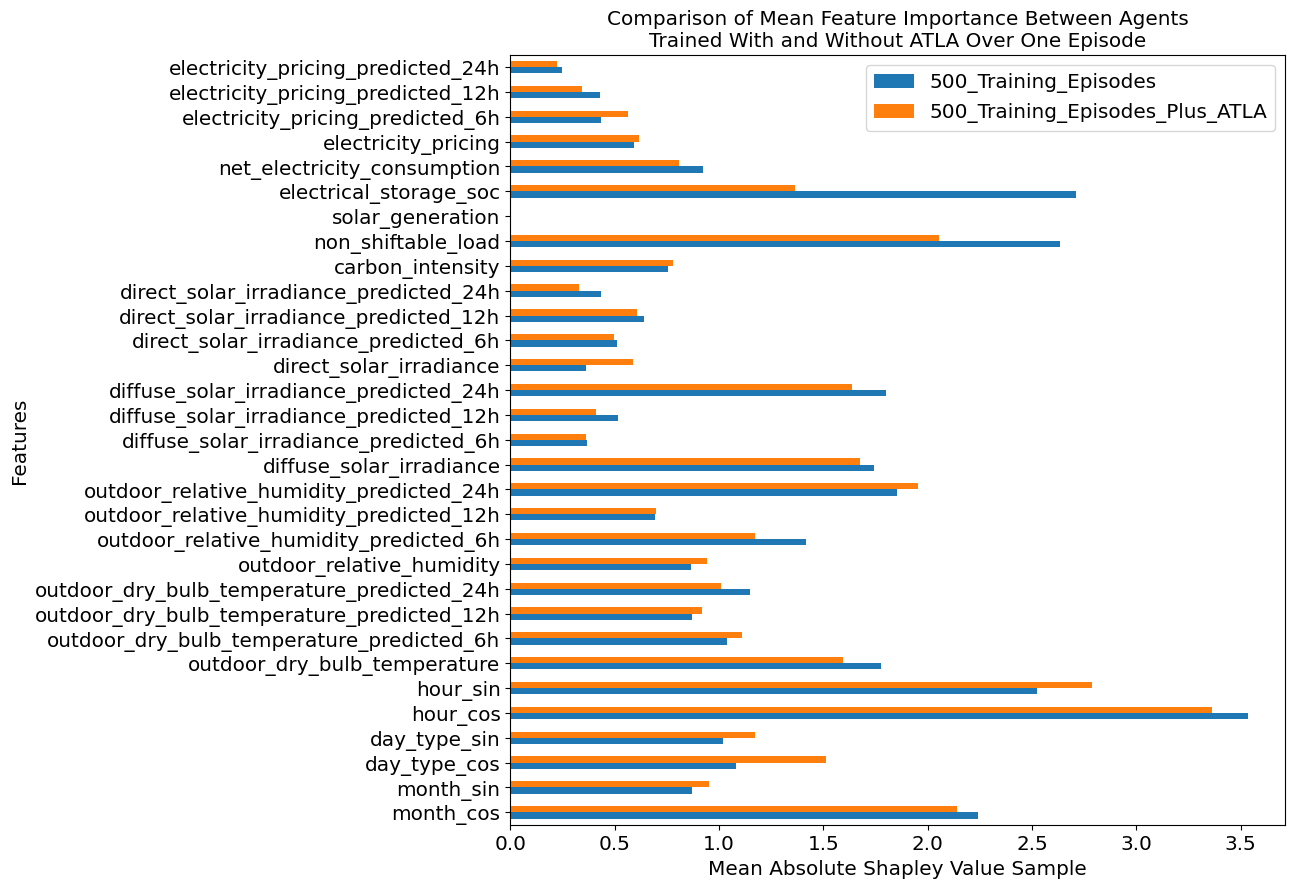

In [13]:
ax = df_mean_shap.T.abs().plot.barh(
    xlabel='Features',
    title='Comparison of Mean Feature Importance Between Agents\nTrained With and Without ATLA Over One Episode',
    figsize=(10,10),
)
ax.set_xlabel('Mean Absolute Shapley Value Sample')
# plt.xlabel('Mean Absolute Shapley Value Sample')
# plt.show()
#plt.tight_layout()

<Axes: title={'center': 'Comparision of Mean Feature Importance Between Agents Trained With and Without ATLA Over One Episode'}, xlabel='Features', ylabel='Mean Absolute Shapley Value Sample'>

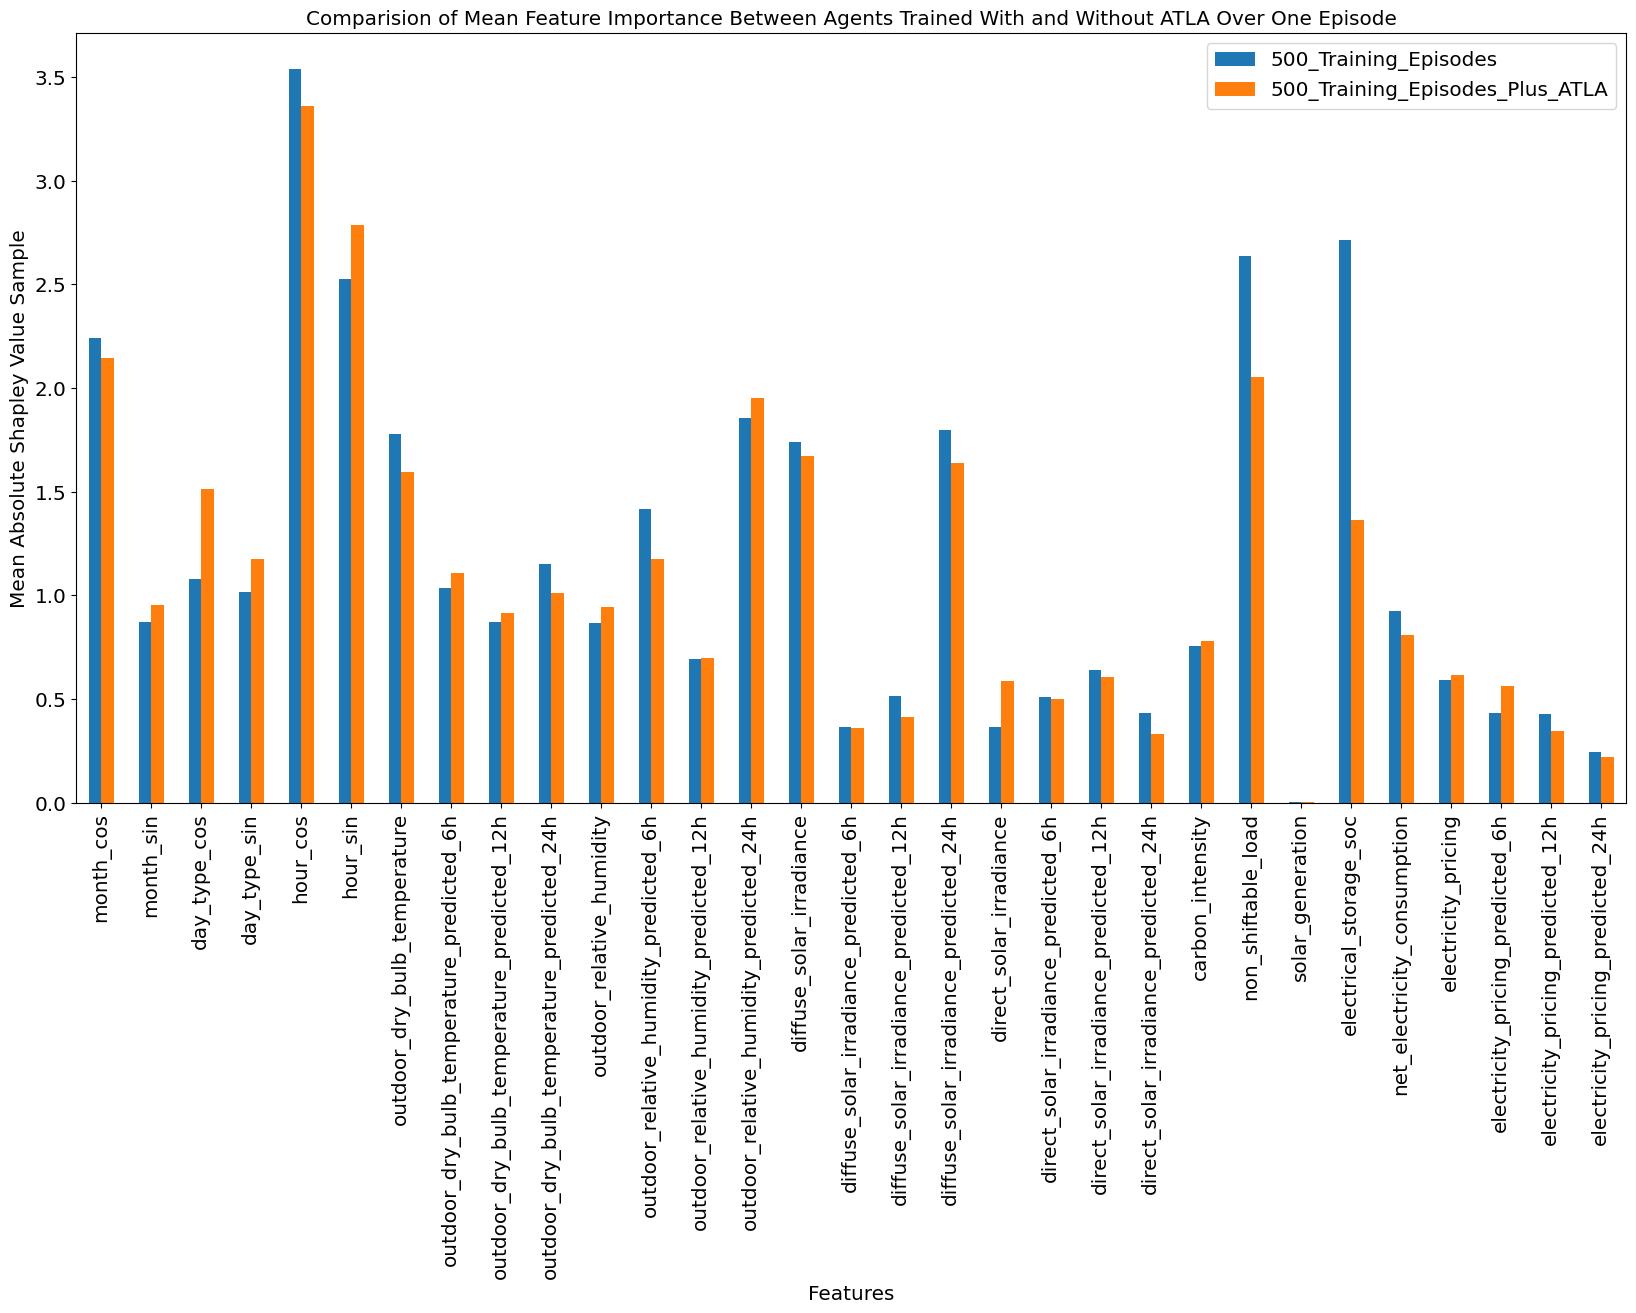

In [14]:
df_mean_shap.T.abs().plot.bar(
    xlabel='Features',
    ylabel='Mean Absolute Shapley Value Sample',
    title='Comparision of Mean Feature Importance Between Agents Trained With and Without ATLA Over One Episode',
    figsize=(20,10),
)

<Axes: title={'center': 'Comparision of Mean Feature Importance Between Agents Trained With and Without ATLA Over One Episode'}, xlabel='Features', ylabel='Mean Absolute Shapley Value Sample'>

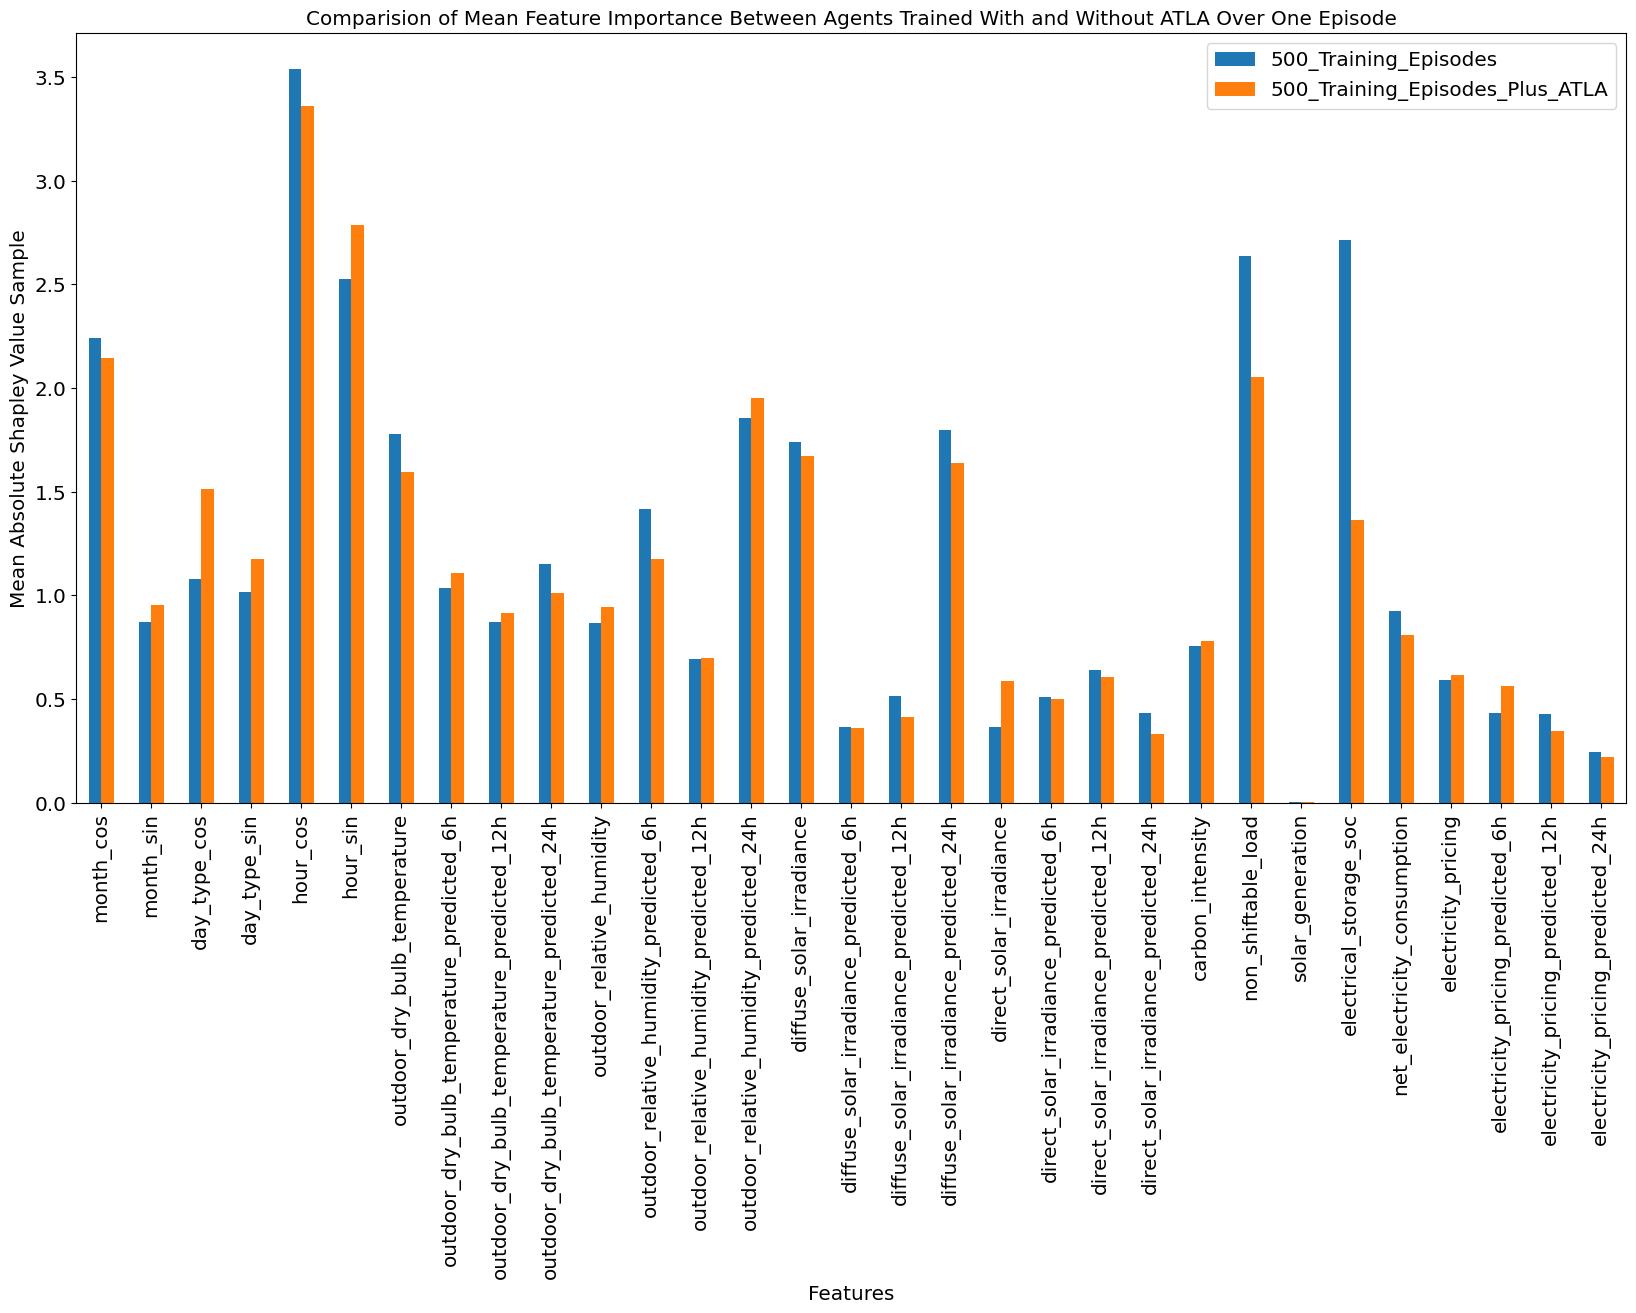

In [15]:
df_mean_shap.T.plot.bar(
    xlabel='Features',
    ylabel='Mean Absolute Shapley Value Sample',
    title='Comparision of Mean Feature Importance Between Agents Trained With and Without ATLA Over One Episode',
    figsize=(20,10),
)

Compared to the conventionally trained agent, the ATLA agent relies more on temporal features (which were not perturbed), while use other less. It also relies more on:
- non-shiftable loads 
- electricity consumption
- electricity price
while ignoring:
- the SoC (intuitively seems important, and second most important feature for the other agent)
- direct solar irradiance (though this wasn't an import feature for the other)
- 12h humidity forecast

TODO: explain where the numbers come from for SVS:

- The number are like forces, increasing or decreasing the prediction from the mean. So large absolute values indicate a feature's importance. 

Should I train an ATLA agent where all features are equally perturbed?

How do these relate to the sizes of mean_diff, are the correlated with the perturbation size? Doesn't look like it

Heatmap like the observation visualizations?

In [16]:
agent_fp_importances = agent_fp.attribute(torch.from_numpy(df_agent.drop(columns=['actions']).to_numpy().astype('float32')).to('cuda'),
                             target=torch.from_numpy(df_agent['actions'].to_numpy().astype('int64')).to('cuda'),
                             show_progress=True,
                             ).detach().cpu().numpy()

Feature Permutation attribution:   0%|          | 0/32 [00:00<?, ?it/s]

In [17]:
atla_fp_importances = agent_fp.attribute(torch.from_numpy(df_atla.drop(columns=['actions']).to_numpy().astype('float32')).to('cuda'),
                             target=torch.from_numpy(df_atla['actions'].to_numpy().astype('int64')).to('cuda'),
                             show_progress=True,
                             ).detach().cpu().numpy()

Feature Permutation attribution:   0%|          | 0/32 [00:00<?, ?it/s]

In [18]:
df_mean_fp = pd.DataFrame([agent_fp_importances.mean(axis=0),atla_fp_importances.mean(axis=0)],
                            index=['500_Training_Episodes','500_Training_Episodes_Plus_ATLA'],
                            columns=df_atla.columns[:-1])

<Axes: title={'center': 'Comparision of Mean Feature Importance Between Agents Trained With and Without ATLA Over One Episode'}, xlabel='Features', ylabel='Mean Feature Permutation Importance'>

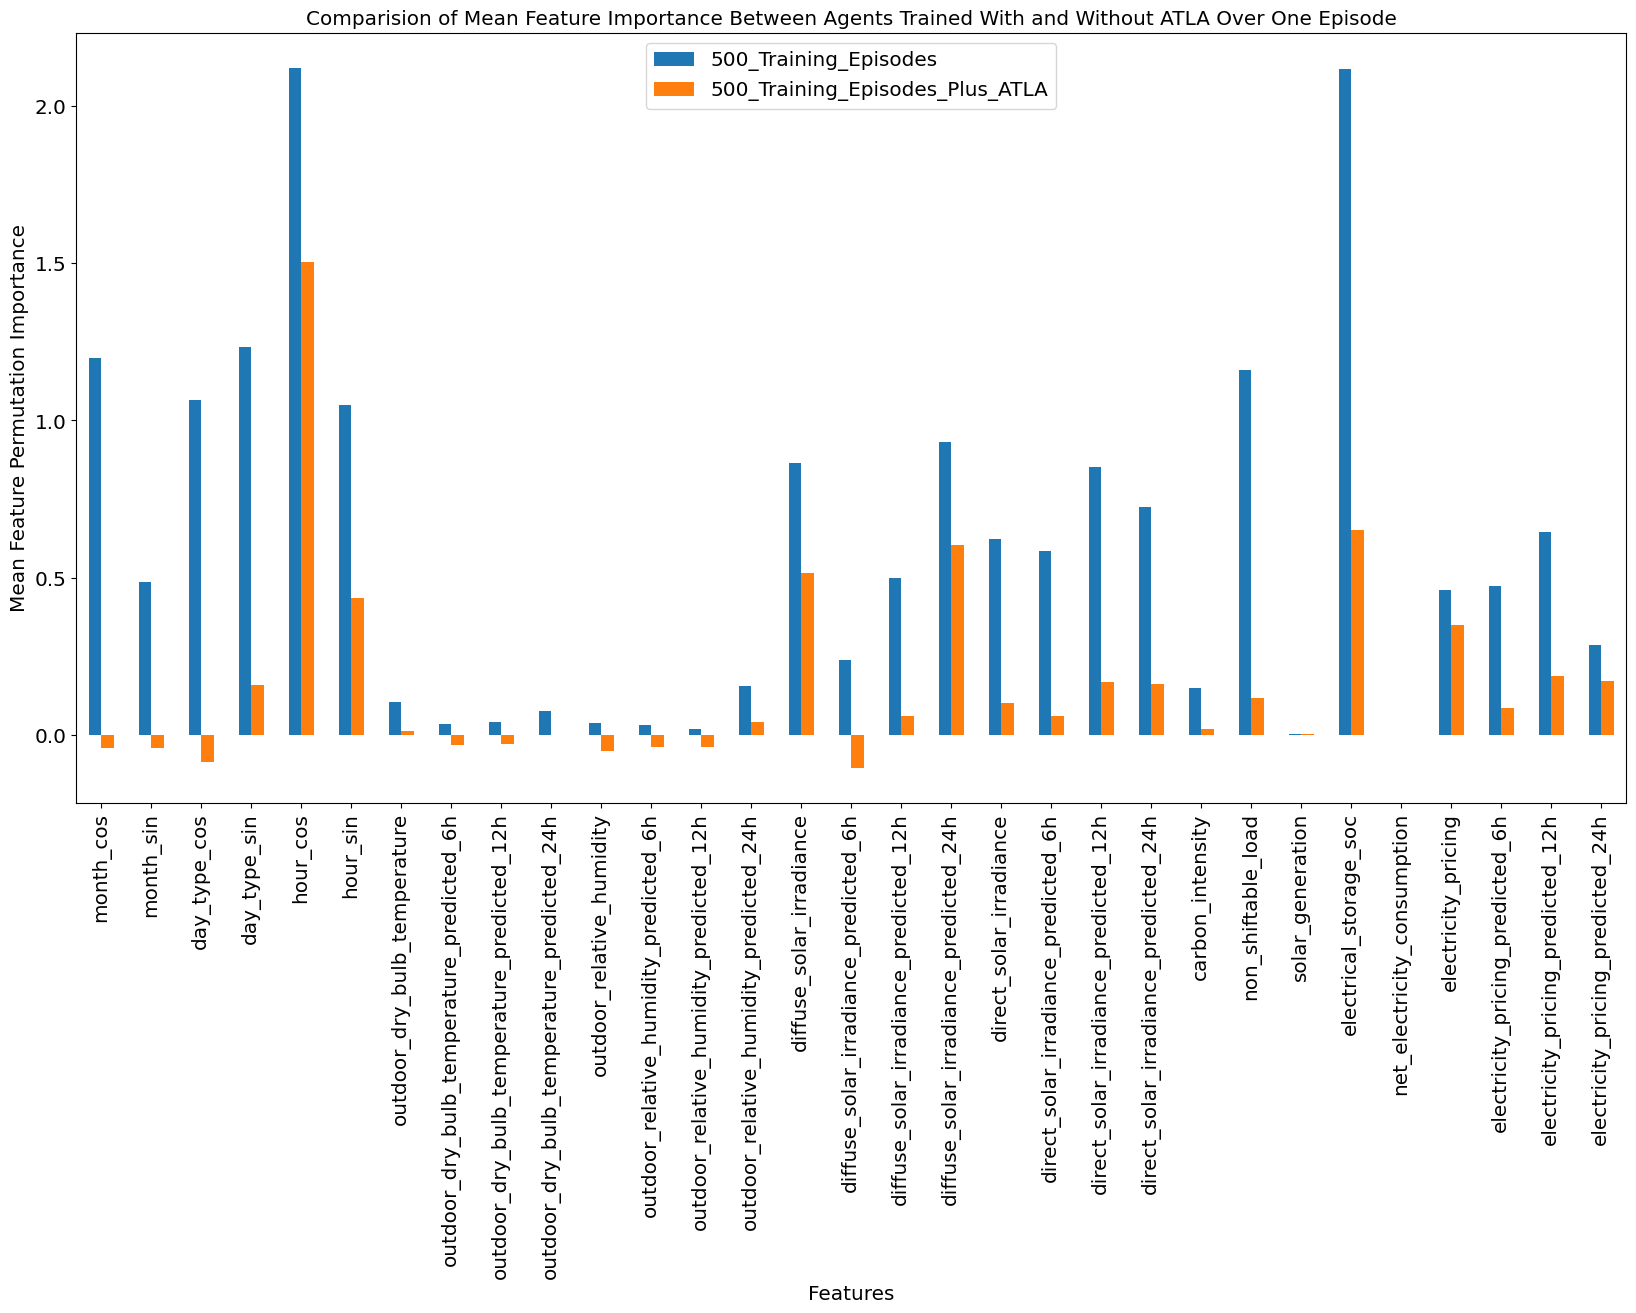

In [19]:
df_mean_fp.T.plot.bar(
    xlabel='Features',
    ylabel='Mean Feature Permutation Importance',
    title='Comparision of Mean Feature Importance Between Agents Trained With and Without ATLA Over One Episode',
    figsize=(20,10),
)

- Negative values indicate that shuffling features is improving model accuracy, because this is a small chance effect, it suggests these features are not important.
- overall we see the ATLA model is less sensitive to feature permutations, which makes sense given that it was trained on them
